## Importando as bibliotecas necessárias

In [1]:
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import (cross_val_score, cross_val_predict, KFold, RandomizedSearchCV
                                     , train_test_split)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
                              , BaggingRegressor, ExtraTreesRegressor)
from sklearn.linear_model import Ridge

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#### Pequenas configurações adicionais

In [2]:
%matplotlib inline
pd.options.display.max_columns = 1000
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style='whitegrid')

#### Explorando os dados

In [3]:
df = pd.read_excel('covid.xlsx', sheet_name=0)

In [6]:
datas = df.iloc[:, 2:]

In [7]:
datas.sample(5)

,TIPOINTERNACAO,tipoidade,internacoes,diarias_leito,diarias_UTI,diarias_UCI,diarias_disponiveis_leito_total,diarias_disponiveis_uti_total,diarias_disponiveis_uci_total,taxa_ocupacao_leitos,taxa_ocupacao_uti,taxa_ocupacao_uci
989,ELETIVO,infancia,5,12,0,0,5301,310,1178,0.002264,0.000000,0.000000
3841,ELETIVO,adulto,123,685,3,0,4185,0,496,0.163680,0.000000,0.000000
416,URGÊNCIA,infancia,115,658,75,0,4495,0,434,0.146385,0.000000,0.000000
4834,URGÊNCIA,infancia,280,1392,100,78,5239,465,1054,0.265700,0.215054,0.074004
1298,ELETIVO,infancia,215,932,204,0,20584,465,3627,0.045278,0.438710,0.000000


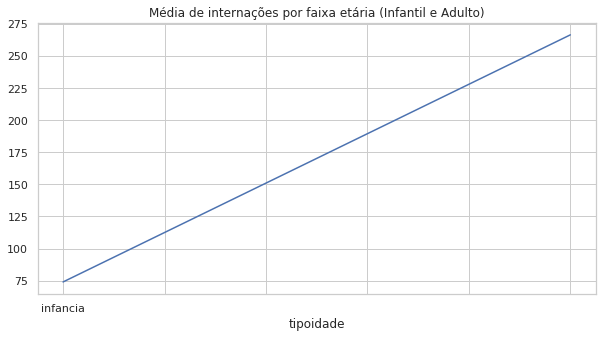

In [6]:
datas.groupby(by='tipoidade')['internacoes'].mean().sort_values().plot()
plt.title('Média de internações por faixa etária (Infantil e Adulto)')
plt.show()

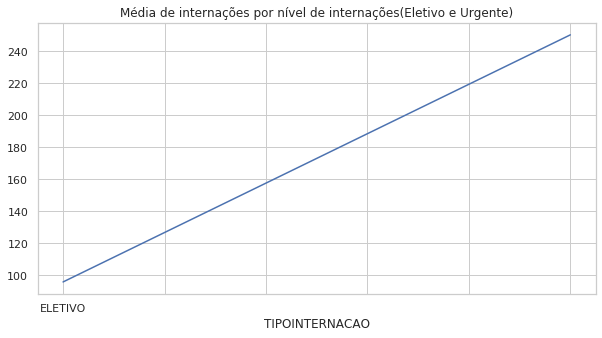

In [7]:
datas.groupby(by='TIPOINTERNACAO')['internacoes'].mean().sort_values().plot()
plt.title('Média de internações por nível de internações(Eletivo e Urgente)')
plt.show()

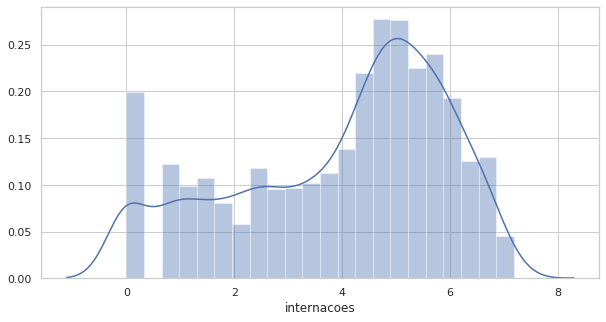

In [9]:
sns.distplot(np.log(datas['internacoes']))
plt.show()

#### Selecionando as variáveis categóricas vs numéricas

In [39]:
num_features = datas[datas.dtypes[datas.dtypes != 'object'].index].copy()
cat_features = datas[datas.dtypes[datas.dtypes == 'object'].index].copy()

#### Plotando o heatmap e verificando a correlação entre variáveis independentes e a target

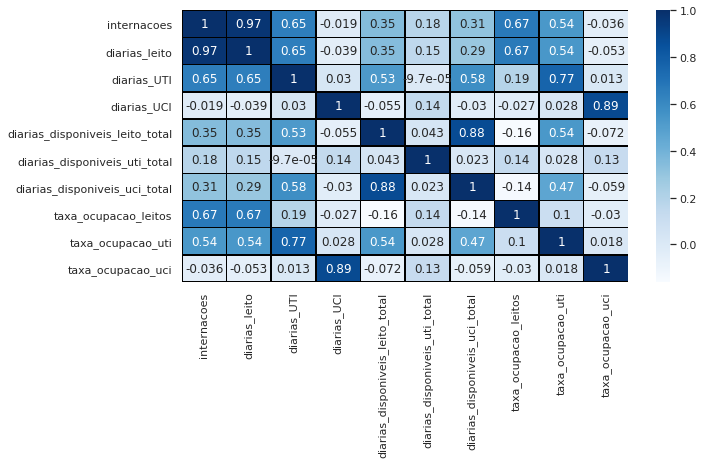

In [14]:
sns.heatmap(num_features.corr(), annot=True, linewidths=0.5, linecolor='black', cmap='Blues')
plt.show()

In [40]:
selected_features = ['diarias_leito', 'diarias_UTI', 'diarias_disponiveis_leito_total'
                     , 'diarias_disponiveis_uti_total', 'taxa_ocupacao_leitos', 'taxa_ocupacao_uti']

In [41]:
fit_features_num = datas[selected_features].copy()

#### Transformando variáveis numéricas

In [42]:
for col in fit_features_num.columns:
    scaler = MinMaxScaler()
    fit_features_num[col] = scaler.fit_transform(fit_features_num[col].values.reshape(-1, 1))

#### Tranformando variáveis categóricas

In [43]:
for col in cat_features.columns:
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
    cat_features[col] = onehot.fit_transform(cat_features[col].values.reshape(-1, 1))

In [47]:
X = pd.concat([fit_features_num, cat_features], axis=1)
y = datas['internacoes']

#### Métricas de avaliação do modelo

In [48]:
def rmsle_log_y(estimator, X, y):
    p = estimator.predict(X)
    return np.sqrt(mean_squared_error(y, p))

def rmsle_sqrt_y(estimator, X, y):
    p = estimator.predict(X)
    y = np.power(y, 2)
    p = np.power(p, 2)
    return np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

In [49]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

## Validação

### Random Forest

### Transformando a variável dependente/Target

#### Log

In [51]:
model = RandomForestRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(model, X, np.log1p(y), cv=kfold, scoring=rmsle_log_y).mean()
error

0.20107751294041415

#### Raiz Quadrada

In [52]:
model = RandomForestRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(model, X, np.sqrt(y), cv=kfold, scoring=rmsle_sqrt_y).mean()
error

0.2047426754732622

### GradientBoosting

#### Log

In [53]:
model = GradientBoostingRegressor(random_state=0)
error = cross_val_score(model, X, np.log1p(y), cv=kfold, scoring=rmsle_log_y).mean()
error

0.2537217838177477

#### Raiz Quadrada

In [54]:
model = GradientBoostingRegressor(random_state=0)
error = cross_val_score(model, X, np.sqrt(y), cv=kfold, scoring=rmsle_sqrt_y).mean()
error

0.2738987109384121

#### AdaBoostRegressor

#### Log

In [55]:
model = AdaBoostRegressor(n_estimators=1000, random_state=0, learning_rate=0.01, loss='square')
error = cross_val_score(model, X, np.log1p(y), cv=kfold, scoring=rmsle_log_y).mean()
error

0.38995888069759216

#### Raiz Quadrada

In [56]:
model = AdaBoostRegressor(n_estimators=1000, random_state=0, learning_rate=0.01, loss='square')
error = cross_val_score(model, X, np.sqrt(y), cv=kfold, scoring=rmsle_sqrt_y).mean()
error

0.43130995691378027

#### BaggingRegressor

#### Log

In [57]:
model = BaggingRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(model, X, np.log1p(y), cv=kfold, scoring=rmsle_log_y).mean()
error

0.2010903238148949

#### Raiz Quadrada

In [58]:
model = BaggingRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(model, X, np.sqrt(y), cv=kfold, scoring=rmsle_sqrt_y).mean()
error

0.20475090286211972

#### ExtraTreesRegressor

#### Log

In [59]:
model = ExtraTreesRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(model, X, np.log1p(y), cv=kfold, scoring=rmsle_log_y).mean()
error

0.1944393124149532

#### Raiz Quadrada

In [60]:
model = ExtraTreesRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(model, X, np.sqrt(y), cv=kfold, scoring=rmsle_sqrt_y).mean()
error

0.1991563888833538

### Turning the model ExtraTreesRegressor

In [61]:
params_grid = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [62]:
etrees = ExtraTreesRegressor(warm_start=True)
etrees_random = RandomizedSearchCV(estimator=etrees, param_distributions=params_grid, 
                               n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)
etrees_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.7min
/home/igoml/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 51.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False...
                   iid=

In [63]:
etrees_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

#### Dividindo a base em treino e teste

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

#### Função para avaliar o desempenho do modelo - Erro logarítmico médio quadrático da raiz

In [73]:
def rmsle_(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error of a prediction set.
    params:
        y_true: numpy array of ground truth
        y_pred: numpy array of predictions
    """
    return np.sqrt(mean_squared_log_error(np.log1p(y_true), y_pred))

### Extra Trees

In [118]:
etrees = ExtraTreesRegressor(**etrees_random.best_params_)
etrees.fit(X_train, np.log1p(y_train))

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=200, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [123]:
y_pred = etrees.predict(X_test)

In [124]:
rmsle_(y_test, y_pred)

0.6712475858660107

## Staking - ExtraTreesRegressor e RandomForestRegressor

In [126]:
kfold_out = KFold(n_splits=5, shuffle=True, random_state=1)
kfold_in = KFold(n_splits=5, shuffle=True, random_state=2)

cv_mean = []

for fold, (tr, ts) in enumerate(kfold_out.split(X, y)):
    
    X_train_cv, X_test_cv = X.iloc[tr], X.iloc[ts]
    y_train_cv, y_test_cv = y.iloc[tr], y.iloc[ts]
    
    models = [ExtraTreesRegressor(**etrees_random.best_params_), 
              RandomForestRegressor(**etrees_random.best_params_)]
    targets = [np.log1p, np.sqrt]
    features_sets = [(X_train_cv, X_test_cv)]
    
    predictions_cv = []
    predictions_test = []
    
    for model, target, feature_set in product(models, targets, features_sets):
        predictions_cv.append(cross_val_predict(model, 
                                                feature_set[0], 
                                                target(y_train_cv), 
                                                cv=kfold_in).reshape(-1, 1))
        model.fit(feature_set[0], target(y_train_cv))
        ptest = model.predict(feature_set[1])
        predictions_test.append(ptest.reshape(-1, 1))
        
    predictions_cv = np.concatenate(predictions_cv, axis=1)
    predictions_test = np.concatenate(predictions_test, axis=1)

    stacker = Ridge()
    stacker.fit(predictions_cv, np.log1p(y_train_cv))
    
    error = rmsle_log_y(stacker, predictions_test, np.log1p(y_test_cv))
    cv_mean.append(error)
    print('RMSLE Fold %d - RMSLE %.4f' % (fold, error))
        
print('RMSLE CV5 %.4f' % np.mean(cv_mean))

RMSLE Fold 0 - RMSLE 0.2011
RMSLE Fold 1 - RMSLE 0.1970
RMSLE Fold 2 - RMSLE 0.1969
RMSLE Fold 3 - RMSLE 0.1862
RMSLE Fold 4 - RMSLE 0.1923
RMSLE CV5 0.1947


In [149]:
y_pred_stack = model[0].predict(X_test_cv)

In [150]:
rmsle_(np.log1p(y_test_cv), y_pred_stack)

1.419592405059593